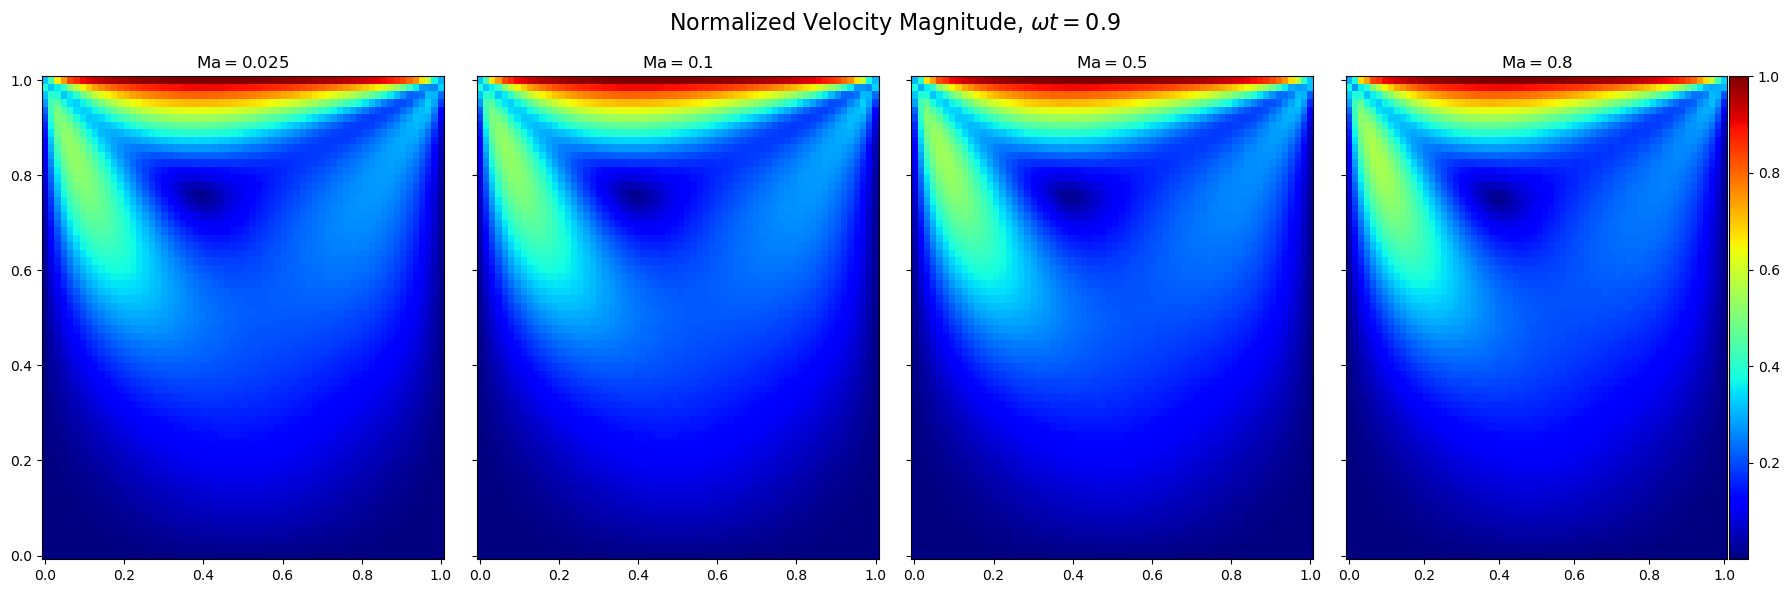

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

field_key = {
    "Density": "Density",
    "VelX1": "X-Velocity",
    "VelX2": "Y-Velocity",
    "Press": "Pressure",
    "Temp": "Temperature",
    "VelMag": "Velocity Magnitude",
    "dpdx": "dpdx",
    "dpdy": "dpdy",
}

dt = 0.1

Time = 9

ds_08 = h5py.File(f"comparison_0.8/test.output.{str(Time).zfill(4)}.h5", "r")
ds_05 = h5py.File(f"comparison_0.5/test.output.{str(Time).zfill(4)}.h5", "r")
ds_01 = h5py.File(f"comparison_0.1/test.output.{str(Time).zfill(4)}.h5", "r")
ds_25 = h5py.File(f"comparison_0.025/test.output.{str(Time).zfill(4)}.h5", "r")

gmax, gmin = 0.0, 1e20

N = 64
field = "VelMag"

for i, ds in enumerate([ds_25, ds_01, ds_05, ds_08]):

    u = np.rot90(ds["VelX1"][:].reshape(N + 2, N + 2)[1:-1, 1:-1], 3)
    v = np.rot90(ds["VelX2"][:].reshape(N + 2, N + 2)[1:-1, 1:-1], 3)

    plotarray = np.sqrt(u**2 + v**2) / np.sqrt(u**2 + v**2).max()

    pmax = np.amax(plotarray)
    pmin = np.amin(plotarray)
    if pmax > gmax:
        gmax = pmax
    else:
        gmax = gmax

    if pmin < gmin:
        gmin = pmin
    else:
        gmin = gmin


fig, ax = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

Mas = [0.025, 0.1, 0.5, 0.8]

for i, ds in enumerate([ds_25, ds_01, ds_05, ds_08]):

    u = np.rot90(ds["VelX1"][:].reshape(N + 2, N + 2)[1:-1, 1:-1], 3)
    v = np.rot90(ds["VelX2"][:].reshape(N + 2, N + 2)[1:-1, 1:-1], 3)

    plotarray = np.sqrt(u**2 + v**2) / np.sqrt(u**2 + v**2).max()

    x, y = np.linspace(0, 1, len(plotarray)), np.linspace(0, 1, len(plotarray))
    X, Y = np.meshgrid(x, y)

    im = ax[i].pcolormesh(X, Y, plotarray, cmap="jet", vmax=gmax, vmin=gmin)
    ax[i].set_title(f"$\mathrm{{Ma}} = ${Mas[i]}")
    if i == 3:
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.02)
        fig.add_axes(cax)
        fig.colorbar(im, cax=cax)

fig.suptitle(
    rf"Normalized {field_key[field]}, $\omega t = ${round(float(Time) * float(dt),7)}", fontsize=16
)
fig.tight_layout()

plt.savefig(f"Ma_comparison.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()


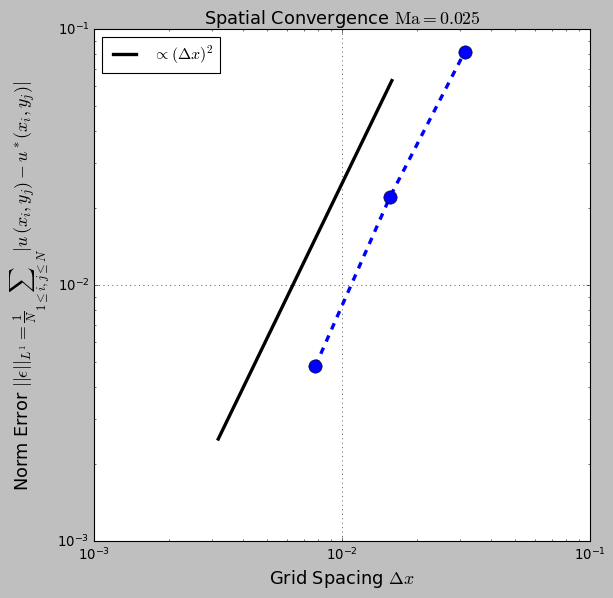

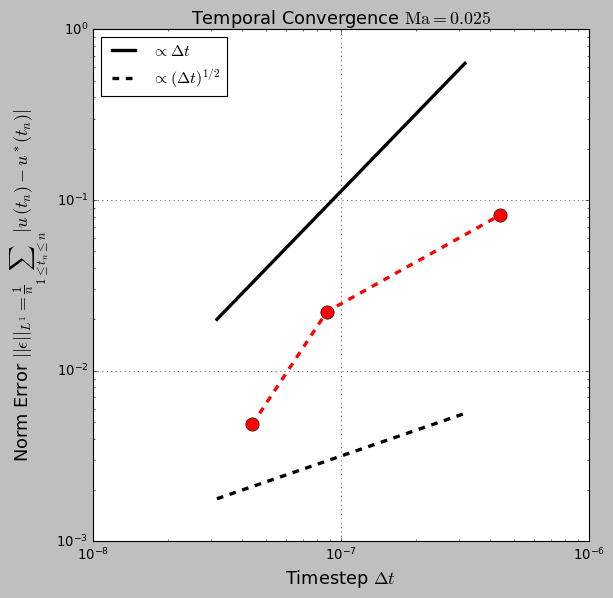

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse

###################################### Spatial Convergence #################################################
Time = 42

ds_16 = h5py.File(f"data/convergence_16x16/test.output.{str(Time).zfill(4)}.h5", "r")
ds_16 = np.rot90(ds_16["VelX1"][:].reshape(16 + 2, 16 + 2)[1:-1, 1:-1], 3)

ds_32 = h5py.File(f"data/convergence_32x32/test.output.{str(Time).zfill(4)}.h5", "r")
ds_32 = np.rot90(ds_32["VelX1"][:].reshape(32 + 2, 32 + 2)[1:-1, 1:-1], 3)

ds_64 = h5py.File(f"data/convergence_64x64/test.output.{str(Time).zfill(4)}.h5", "r")
ds_64 = np.rot90(ds_64["VelX1"][:].reshape(64 + 2, 64 + 2)[1:-1, 1:-1], 3)

ds_128 = h5py.File(f"data/convergence_128x128/test.output.{str(Time).zfill(4)}.h5", "r")
ds_128 = np.rot90(ds_128["VelX1"][:].reshape(128 + 2, 128 + 2)[1:-1, 1:-1], 3)

eps_128_64 = abs(ds_128[128 // 2, 128 // 2] - ds_64[64 // 2, 64 // 2])
eps_64_32 = abs(ds_128[128 // 2, 128 // 2] - ds_32[32 // 2, 32 // 2])
eps_32_16 = abs(ds_128[128 // 2, 128 // 2] - ds_16[16 // 2, 16 // 2])

dxs = [1 / 128, 1 / 64, 1 / 32]
eps = [eps_128_64, eps_64_32, eps_32_16]

plt.style.use("classic")
fig = plt.figure(figsize=(8, 8))

plt.plot(dxs, eps, "--", marker="o", markersize=12, linewidth=3, color="blue")
plt.plot(
    0.2 * (np.logspace(-1.8, -1.1, 100)),
    10 * (np.logspace(-1.8, -1.1, 100)) ** (2),
    "-",
    linewidth=3,
    color="black",
    label="$\propto (\Delta x)^{2}$",
)

plt.yscale("log")
plt.xscale("log")

plt.xlabel(r"Grid Spacing $\Delta x$", fontsize=16)
plt.ylabel(
    r"Norm Error $||\epsilon||_{L^1} = \frac{1}{N} \sum_{1 \leq i,j \leq N} |u \, (x_i, y_j) - u^*(x_i, y_j)|$",
    fontsize=16,
)
plt.title(r"Spatial Convergence $\mathrm{Ma} = 0.025$", fontsize=16)

plt.minorticks_on()
plt.legend(loc="upper left")
plt.grid()

plt.savefig("spatial_convergence.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

# print("slope = ",(eps[-1] - eps[0])/(dxs[-1] - dxs[0]))

###################################### Temporal Convergence ############################################

Time = 41

ds_01 = h5py.File(f"data/time_conv_01/test.output.{str(Time).zfill(4)}.h5", "r")
ds_01 = np.rot90(ds_01["VelX1"][:].reshape(32 + 2, 32 + 2)[1:-1, 1:-1], 3)

ds_005 = h5py.File(f"data/time_conv_005/test.output.{str(Time).zfill(4)}.h5", "r")
ds_005 = np.rot90(ds_005["VelX1"][:].reshape(32 + 2, 32 + 2)[1:-1, 1:-1], 3)

ds_001 = h5py.File(f"data/time_conv_001/test.output.{str(Time).zfill(4)}.h5", "r")
ds_001 = np.rot90(ds_001["VelX1"][:].reshape(32 + 2, 32 + 2)[1:-1, 1:-1], 3)

ds_0005 = h5py.File(f"data/time_conv_0005/test.output.{str(Time).zfill(4)}.h5", "r")
ds_0005 = np.rot90(ds_0005["VelX1"][:].reshape(32 + 2, 32 + 2)[1:-1, 1:-1], 3)

eps_0005_001 = abs(ds_0005[32 // 2, 32 // 2] - ds_001[32 // 2, 32 // 2])
eps_001_005 = abs(ds_0005[32 // 2, 32 // 2] - ds_005[32 // 2, 32 // 2])
eps_005_01 = abs(ds_0005[32 // 2, 32 // 2] - ds_01[32 // 2, 32 // 2])

dts = [4.39067e-8, 8.78134e-8, 4.39067e-7]
eps = [eps_0005_001, eps_001_005, eps_005_01]

plt.style.use("classic")
fig = plt.figure(figsize=(8, 8))

plt.plot(dts, eps, "--", marker="o", markersize=12, linewidth=3, color="red")
plt.plot(
    np.logspace(-7.5, -6.5, 100),
    20 * (np.logspace(-3, -1.5, 100)),
    "-",
    linewidth=3,
    color="black",
    label="$\propto \Delta t$",
)
plt.plot(
    np.logspace(-7.5, -6.5, 100),
    10 * (np.logspace(-7.5, -6.5, 100)) ** (1 / 2),
    "--",
    linewidth=3,
    color="black",
    label="$\propto (\Delta t)^{1/2}$",
)

plt.yscale("log")
plt.xscale("log")

plt.xlabel(r"Timestep $\Delta t$", fontsize=16)
plt.ylabel(
    r"Norm Error $||\epsilon||_{L^1} = \frac{1}{n} \sum_{1 \leq t_n \leq n} |u \, (t_n) - u^*(t_n)|$",
    fontsize=16,
)
plt.title(r"Temporal Convergence $\mathrm{Ma} = 0.025$", fontsize=16)

plt.minorticks_on()
plt.legend(loc="upper left")
plt.grid()

plt.savefig("temporal_convergence.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

# print("slope = ",(eps[-1] - eps[0])/(dts[-1] - dts[0]))

